In [51]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
plt.rcParams['figure.figsize'] = [20, 10]
plt.rc('xtick', labelsize=20)     
plt.rc('ytick', labelsize=20)

## Data preparation

In [102]:
pass_df = pd.read_csv("international-airline-passengers.csv")
pass_df.tail()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [103]:
pass_df = pass_df.iloc[:-1]

In [104]:
pass_df.tail()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [105]:
pass_df["dt"] = pass_df["Month"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m'))

In [106]:
pass_df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60,dt
0,1949-01,112.0,1949-01-01
1,1949-02,118.0,1949-02-01
2,1949-03,132.0,1949-03-01
3,1949-04,129.0,1949-04-01
4,1949-05,121.0,1949-05-01


In [107]:
pass_df = pass_df\
    .rename({"International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60": "Passengers"}, axis=1)\
    .drop("Month", axis=1)


In [108]:
pass_df.head()

,Passengers,dt
0,112.0,1949-01-01
1,118.0,1949-02-01
2,132.0,1949-03-01
3,129.0,1949-04-01
4,121.0,1949-05-01


We plot our time series 

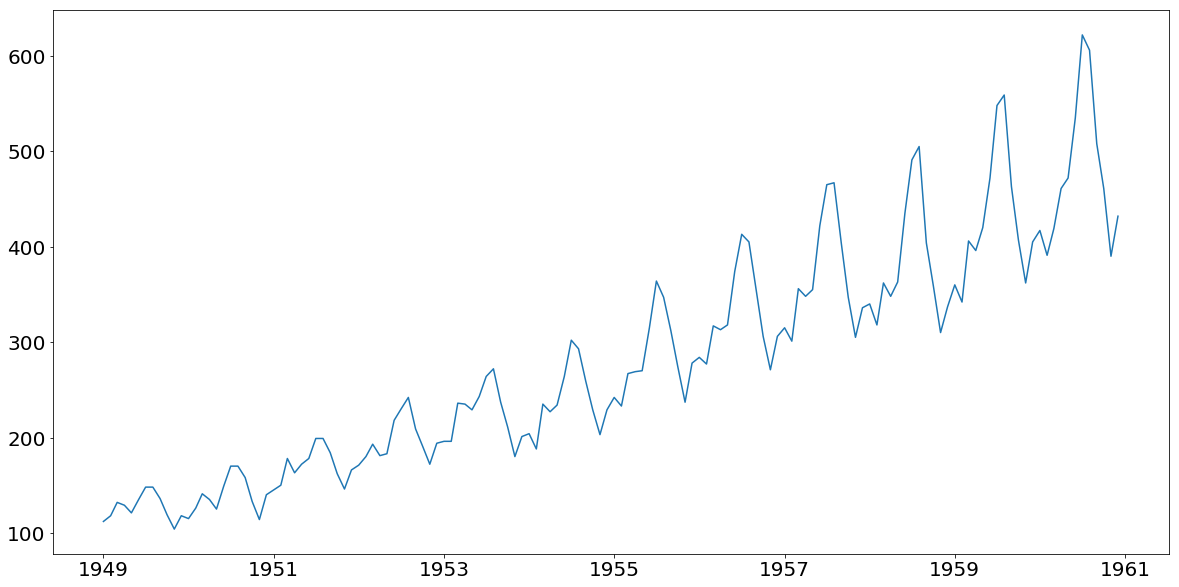

In [109]:
plt.plot(pass_df["dt"], pass_df["Passengers"])

We verify we have data for all months each year

In [110]:
pass_df[['dt']].groupby(pass_df['dt'].dt.year).count()

,dt
dt,
1949,12
1950,12
1951,12
1952,12
1953,12
1954,12
1955,12
1956,12
1957,12


We are going to split the dataset in Train, Validation and Test data. For that we will sort the values so that validation and test dates are posterior to train dates. We are going to use train data to predict validation and test values.

In [149]:
Xy = pass_df[['dt', 'Passengers']]

def create_X_and_y(Xy, target_column='Passengers'):
    return Xy.drop(target_column, axis=1), Xy[target_column]

def split_into_train_dev_test(Xy):
    X_train, y_train = create_X_and_y(Xy.query("dt < '1959'"))
    X_dev, y_dev = create_X_and_y(Xy.query("dt >= '1959' and dt < '1960'"))
    X_test, y_test = create_X_and_y(Xy.query("dt >= '1960'"))
    return X_train, X_dev, X_test, y_train, y_dev, y_test

X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy)

## Model 1: the average of all the previous number of passengers

A very simple model is to predict the future with the value of the average of all previous data

In [150]:
y_dev_hat = np.ones(len(y_dev)) * y_train.mean()

In [151]:
y_train.mean()

245.90833333333333

Let's plot its performance

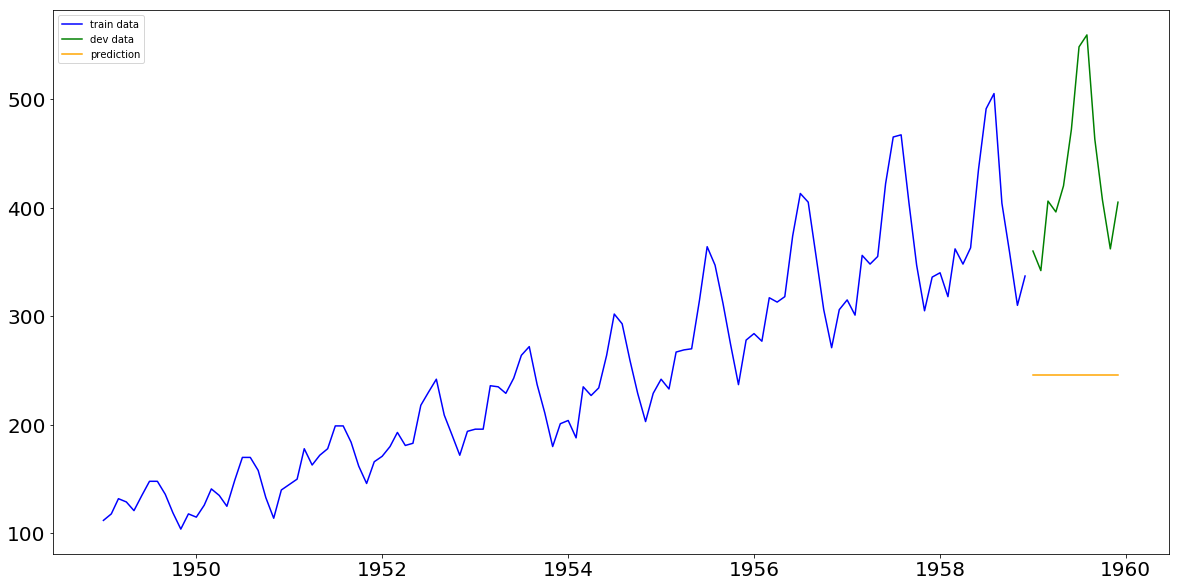

In [152]:
def plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat):
    plt.plot(X_train["dt"], y_train, c="blue", label='train data')
    plt.plot(X_dev["dt"], y_dev, c="green", label='dev data')
    plt.plot(X_dev["dt"], y_dev_hat, c="orange", label='prediction')
    plt.legend()
    plt.show()
    
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [153]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  37748.769513888896
RMSE:  194.29042568765166


## Model 2: average of previous year

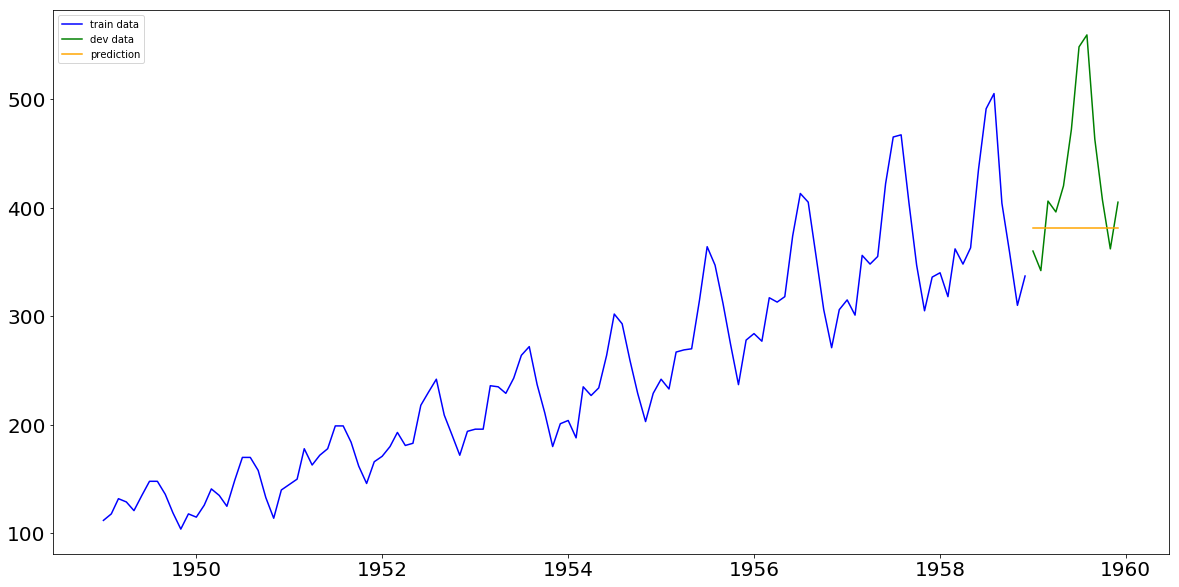

In [154]:
y_dev_hat = np.ones(len(y_dev)) * y_train[-12:].mean()
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [155]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  6710.333333333333
RMSE:  81.91662427940578


## Model 3: value of previous month

In [156]:
Xy_with_lags = Xy.copy()
Xy_with_lags['Passengers-1'] = Xy_with_lags['Passengers'].shift(1)
Xy_with_lags.head(3)

,dt,Passengers,Passengers-1
0,1949-01-01,112.0,NaN
1,1949-02-01,118.0,112.0
2,1949-03-01,132.0,118.0


In [157]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

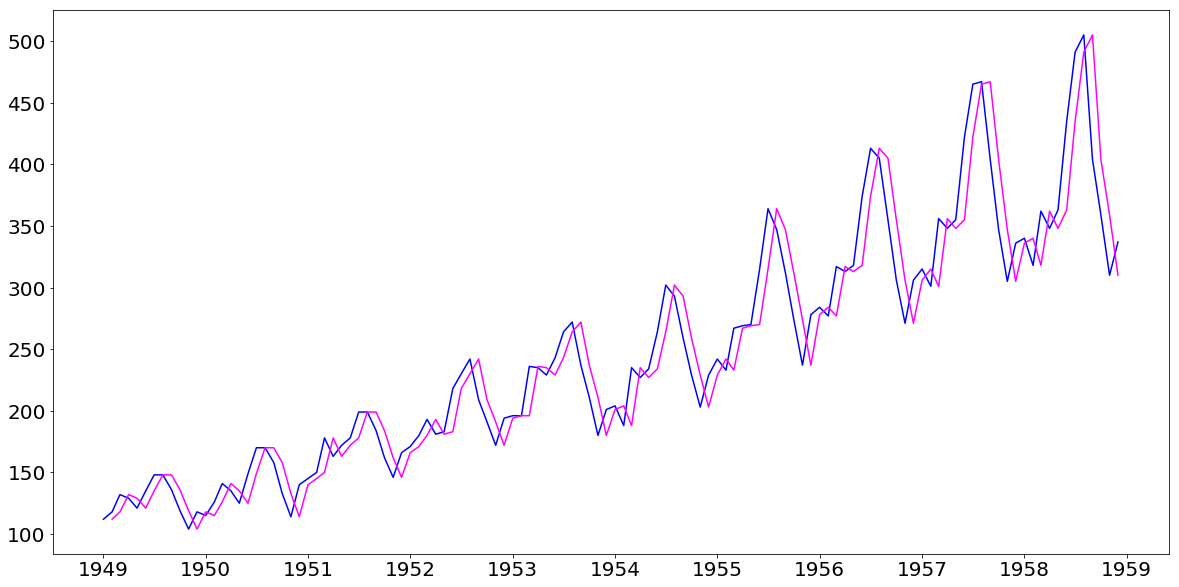

In [158]:
y_train_hat = X_train['Passengers-1']
plt.plot(X_train["dt"], y_train, c="blue", label='airline passengers data')
plt.plot(X_train["dt"], y_train_hat, c="magenta", label='prediction airline passengers data')

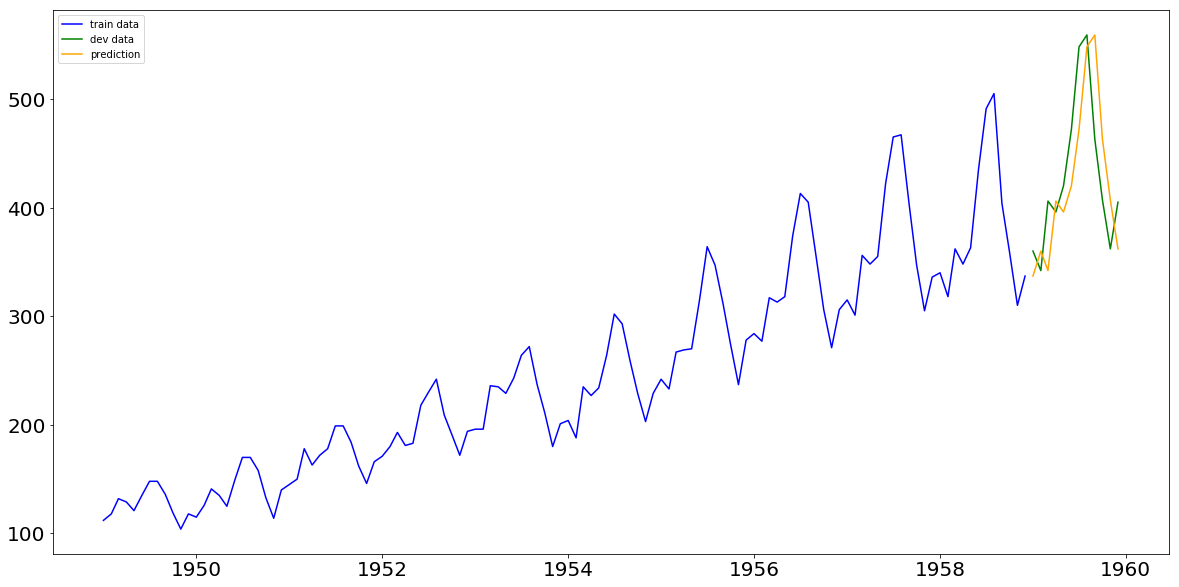

In [159]:
y_dev_hat = X_dev['Passengers-1']
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [160]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  2537.6666666666665
RMSE:  50.37525847741792


## Model 4: Autoregresion (AR) Model

In [161]:
N_lags = 12

def create_lags(Xy, n_lags):
    Xy_with_lags = Xy.copy()
    for i in range(1, n_lags+1):
        Xy_with_lags['Passengers-'+str(i)] = Xy_with_lags['Passengers'].shift(i)
    return Xy_with_lags

Xy_with_lags = create_lags(Xy, N_lags)
autocorrelations = Xy_with_lags.iloc[N_lags:].drop("dt", axis=1).corr()['Passengers']

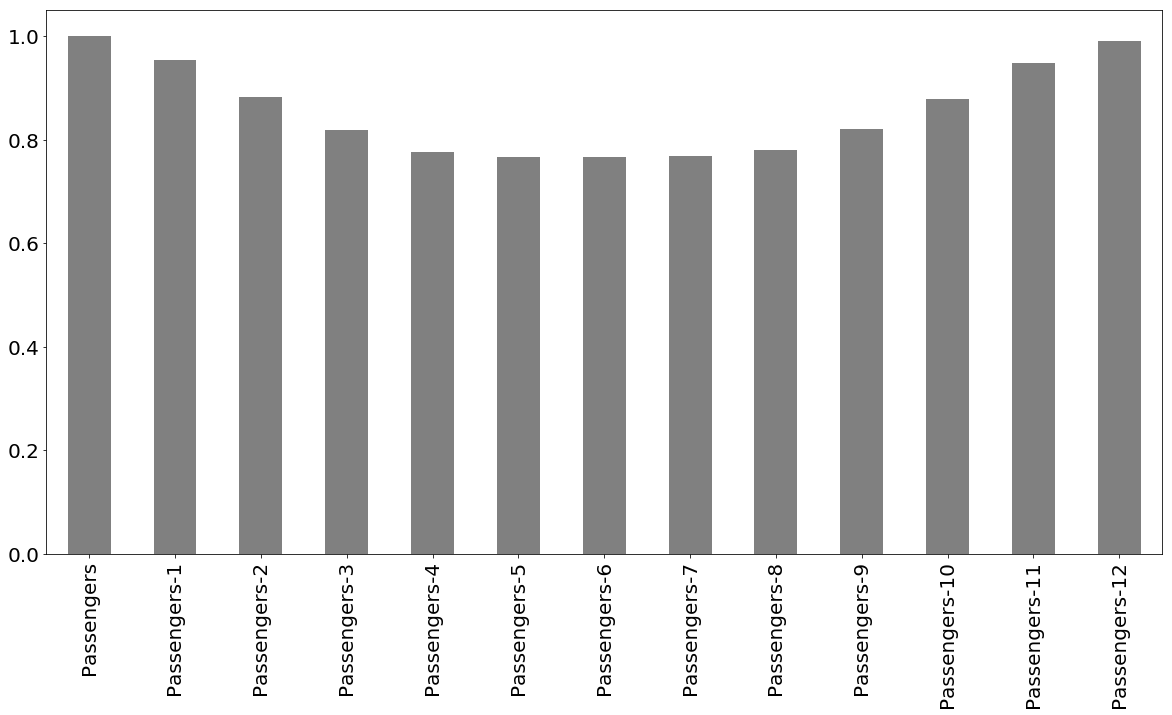

In [162]:
autocorrelations.plot(kind='bar',color='gray')

In [163]:
columns_for_ar = autocorrelations[np.abs(autocorrelations) > 0.15].index[1:]
columns_for_ar

Index(['Passengers-1', 'Passengers-2', 'Passengers-3', 'Passengers-4',
       'Passengers-5', 'Passengers-6', 'Passengers-7', 'Passengers-8',
       'Passengers-9', 'Passengers-10', 'Passengers-11', 'Passengers-12'],
      dtype='object')

In [164]:
Xy_with_lags.head(3)

,dt,Passengers,Passengers-1,Passengers-2,Passengers-3,Passengers-4,Passengers-5,Passengers-6,Passengers-7,Passengers-8,Passengers-9,Passengers-10,Passengers-11,Passengers-12
0,1949-01-01,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1949-02-01,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1949-03-01,132.0,118.0,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [165]:
Xy_with_lags = Xy_with_lags.iloc[N_lags:].reset_index(drop=True)
Xy_with_lags.head()

,dt,Passengers,Passengers-1,Passengers-2,Passengers-3,Passengers-4,Passengers-5,Passengers-6,Passengers-7,Passengers-8,Passengers-9,Passengers-10,Passengers-11,Passengers-12
0,1950-01-01,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
1,1950-02-01,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
2,1950-03-01,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
3,1950-04-01,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
4,1950-05-01,125.0,135.0,141.0,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [166]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)

from sklearn.linear_model import LinearRegression

def train_and_test_linear_model(X_train, y_train, X_dev, y_dev):
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_dev_hat = reg.predict(X_dev)
    return reg, np.sqrt(mean_squared_error(y_dev, y_dev_hat))


reg, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

y_dev_hat = reg.predict(X_dev.drop("dt", axis=1)[columns_for_ar])
rmse

15.72527862810318

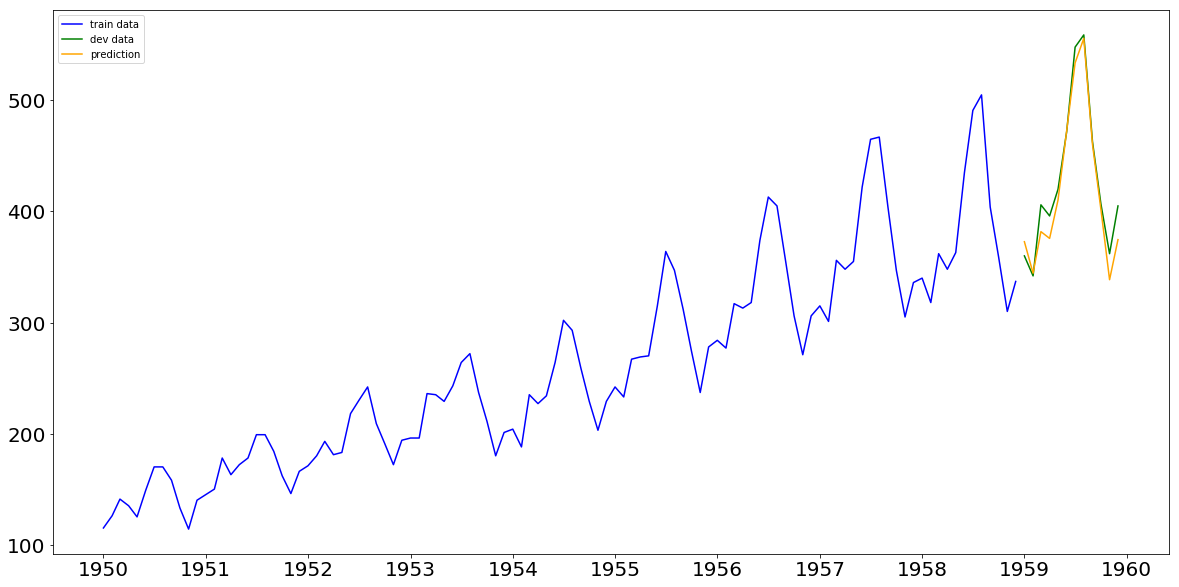

In [167]:
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

In [168]:
columns_for_ar = ["Passengers-" + str(i) for i in range(1, 13)]

reg_all_columns, rmse = train_and_test_linear_model(
    X_train.drop("dt", axis=1)[columns_for_ar], y_train, 
    X_dev.drop("dt", axis=1)[columns_for_ar], y_dev)

rmse

15.72527862810318

## Model 5: Recurrent prediction

Often we look for a year long prediction

In [170]:
def recurrent_prediction(y_train, n_steps, reg):
    x_dev = list(y_train[-1:-(n_steps +1):-1])
    y_dev_hat = []
    for i in range(n_steps):
        y_hat = reg.predict([x_dev])[0]
        y_dev_hat.append(y_hat)
        x_dev.pop(-1)
        x_dev = [y_hat] + x_dev
    return y_dev_hat

y_dev_hat = recurrent_prediction(y_train, 12, reg_all_columns)
#np.sqrt(mean_squared_error(y_dev, y_dev_hat))

In [171]:
from sklearn.metrics import mean_squared_error

print("MSE: " ,mean_squared_error(y_dev, y_dev_hat))
print("RMSE: ", np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

MSE:  382.1697932552511
RMSE:  19.54916349246819


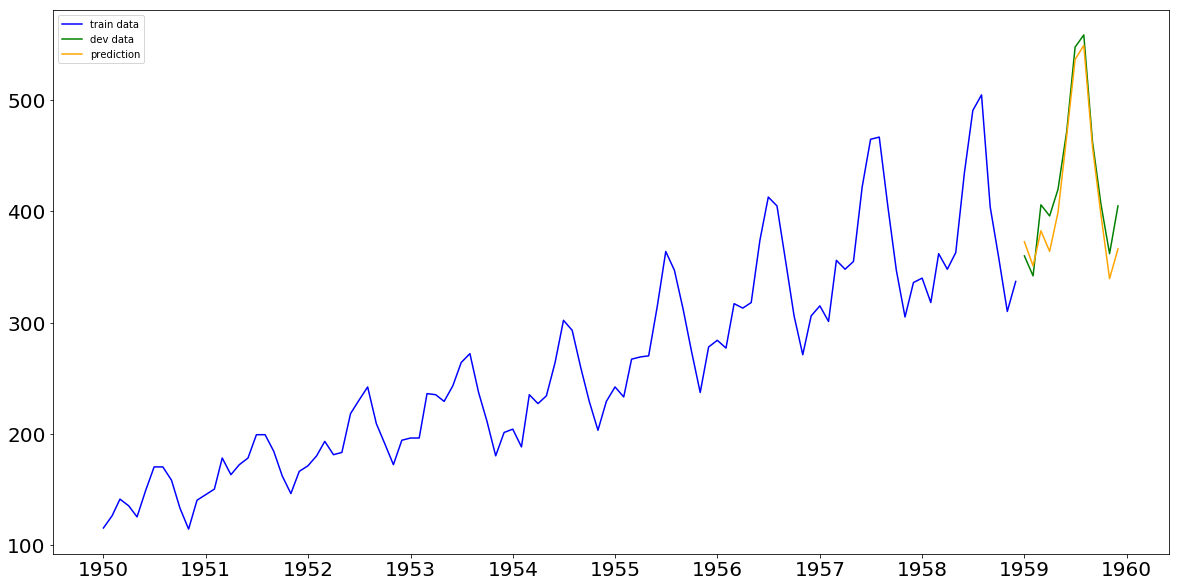

In [173]:
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

##  Modelo 6: K-nearest neighborhood 

In [174]:
from sklearn.neighbors import KNeighborsRegressor
N_lags = 12
Xy_with_lags = create_lags(Xy, N_lags).iloc[N_lags:]
X_train, X_dev, X_test, y_train, y_dev, y_test = split_into_train_dev_test(Xy_with_lags)
reg_kn = KNeighborsRegressor(n_neighbors=5)
reg_kn.fit(X_train.drop("dt", axis=1), y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

> __Note__: It's very important to understand to evaluate the model in the validation dates what is our objective:
    
1) We are in January 1967 and we want to predict the whole year:

in this case we need to predict in an iterative model: if we are in April 1967, and we dont know January, February or March, 
    and I need the last 12 lags, the only way to predict is to do it by recurrent model, predicting January, February and Marc
h using previous months. 

For this the model would predict using:

y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)

2) We are at a month of 1967 and we want to predict the following month:

reg_kn.predict(X_dev.drop("dt", axis=1))

In [175]:
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

57.255101664975385

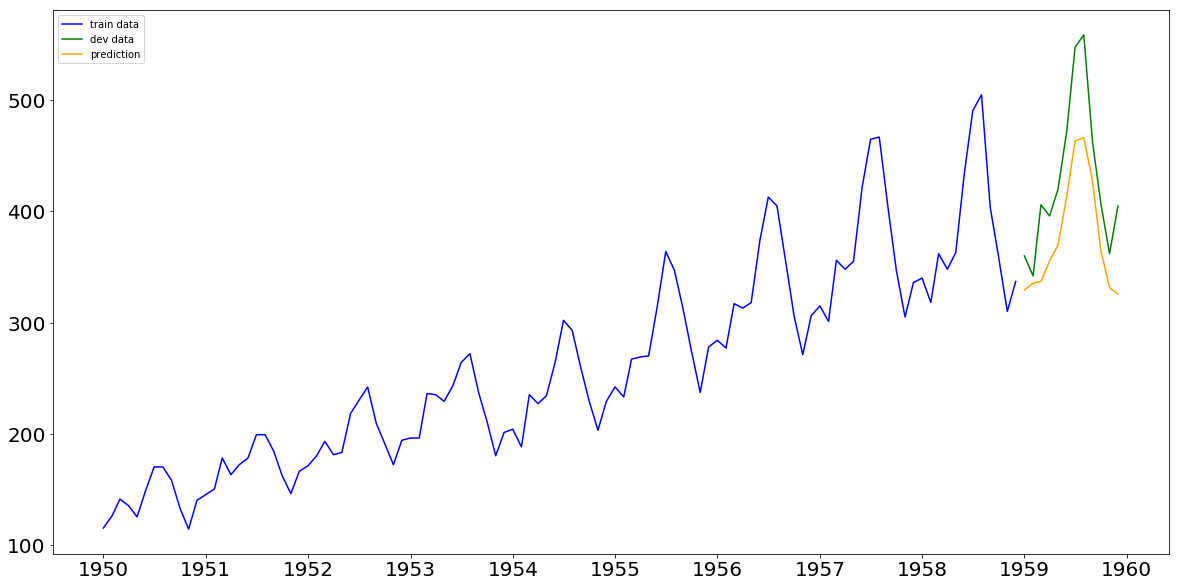

In [177]:
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

 Grid search of best parameters

In [178]:
performance = pd.DataFrame()   

for n_neighbors in [2, 3, 4, 5, 6, 7, 8]:
    reg_kn = KNeighborsRegressor(n_neighbors=n_neighbors)
    reg_kn.fit(X_train.drop("dt", axis=1), y_train)
    y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
    rmse = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
    new_row = pd.DataFrame({
        "n_neighbours": [n_neighbors], 
        "rmse": [rmse]
    })
    performance = performance.append(new_row, ignore_index = True)
performance.sort_values("rmse").head()

,n_neighbours,rmse
1,3,49.207798
2,4,50.448096
0,2,55.491366
3,5,57.255102
6,8,59.055257


##  Modelo 7: Random Forest

In [180]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/Users/ione/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [181]:
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
reg_rf = RandomForestRegressor(random_state=667)
reg_rf.fit(X_train.drop("dt", axis=1), y_train)
y_dev_hat = recurrent_prediction(y_train, N_lags, reg_rf)
#y_dev_hat = reg_rf.predict(X_dev.drop("dt", axis=1))
np.sqrt(mean_squared_error(y_dev, y_dev_hat))

43.78824994599959

In [182]:
performance = pd.DataFrame()   

for n_estimators in [2, 5, 7, 10, 20, 100]:
    for max_depth in [5, 7, 10, 20]:
        reg_kn = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=667)
        reg_kn.fit(X_train.drop("dt", axis=1), y_train)
        y_dev_hat = recurrent_prediction(y_train, N_lags, reg_kn)
        rmse = np.sqrt(mean_squared_error(y_dev, y_dev_hat))
        new_row = pd.DataFrame({
            "n_estimators": [n_estimators], 
            "max_depth": [max_depth],
            "rmse": [rmse]
        })
        performance = performance.append(new_row, ignore_index = True)
performance.sort_values("rmse").head()

,n_estimators,max_depth,rmse
5,5,7,38.831696
19,20,20,39.453095
6,5,10,39.482908
20,100,5,39.515699
18,20,10,39.589703


In [184]:
X_train_dev = pd.concat([X_train, X_dev])
y_train_dev = np.concatenate([y_train, y_dev])

reg_rf = RandomForestRegressor(n_estimators=5, max_depth=7, random_state=667)
reg_rf.fit(X_train_dev.drop("dt", axis=1), y_train_dev)
y_test_hat = recurrent_prediction(y_test, N_lags, reg_rf)
np.sqrt(mean_squared_error(y_test, y_test_hat))

58.850606340688365

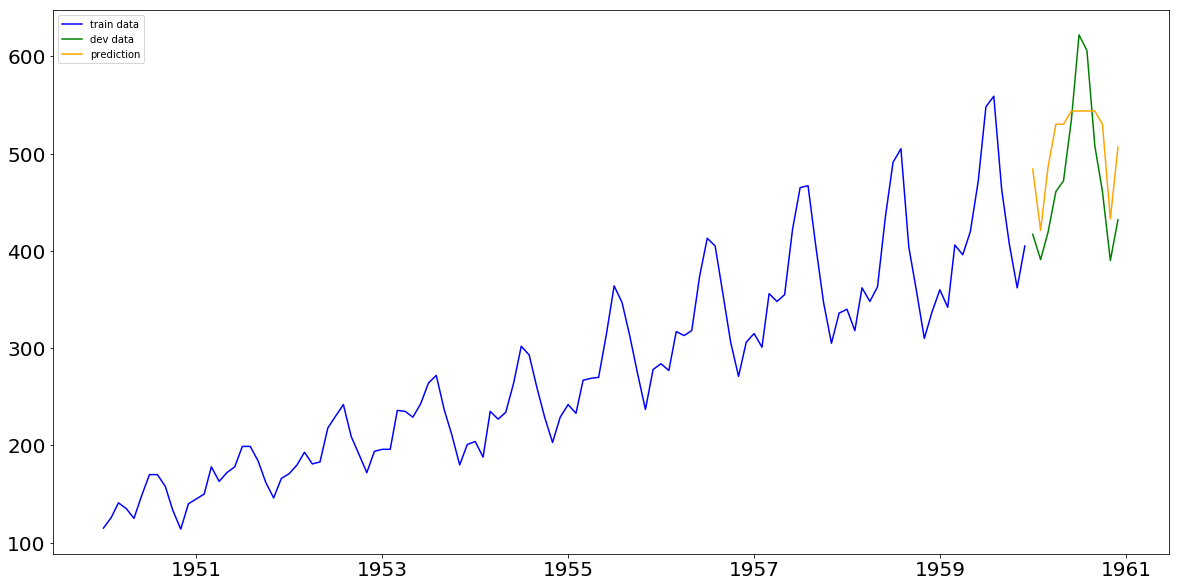

In [186]:
plot_prediction(X_train_dev, y_train_dev, X_test, y_test, y_test_hat)

## Modelo 8: Autoregression (AR) 

In [188]:
from statsmodels.tsa.ar_model import AR
model = AR(y_train)
model_fit = model.fit(maxlag=12)
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

21.62355517943211


/Users/ione/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ione/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


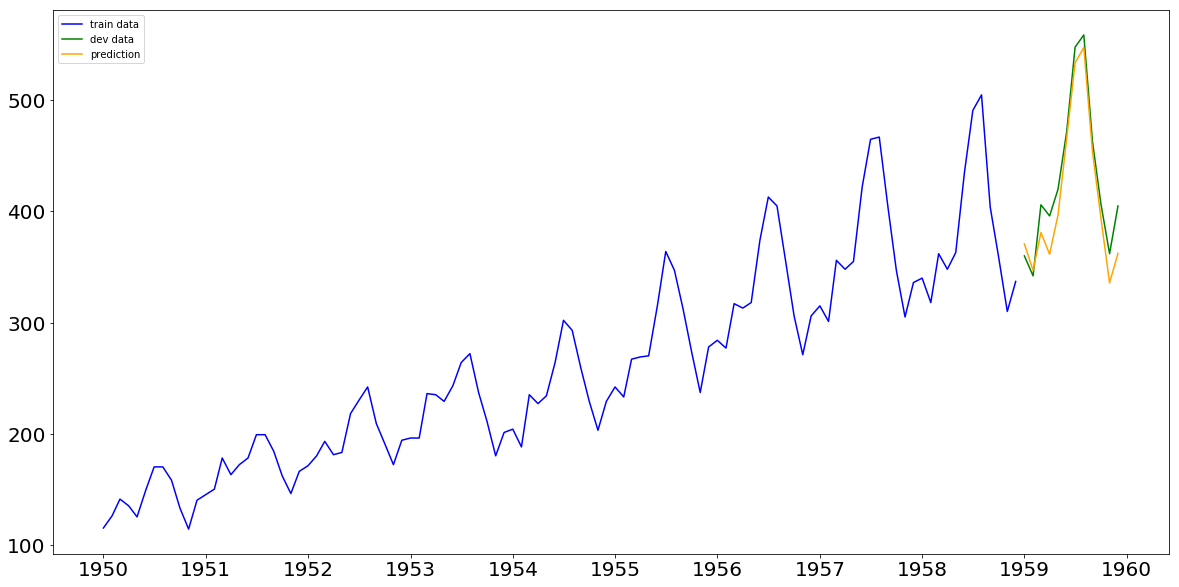

In [190]:
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)

## Modelo 8: Autoregression Moving Average (ARIMA) 

In [191]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(y_train, order=(9, 2))
model_fit = model.fit(disp=0, start_ar_lags=13)

/Users/ione/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ione/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [192]:
y_dev_hat = model_fit.predict(start=len(y_train), end=len(y_train)+11)    
print(np.sqrt(mean_squared_error(y_dev, y_dev_hat)))

39.119412296799894


/Users/ione/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


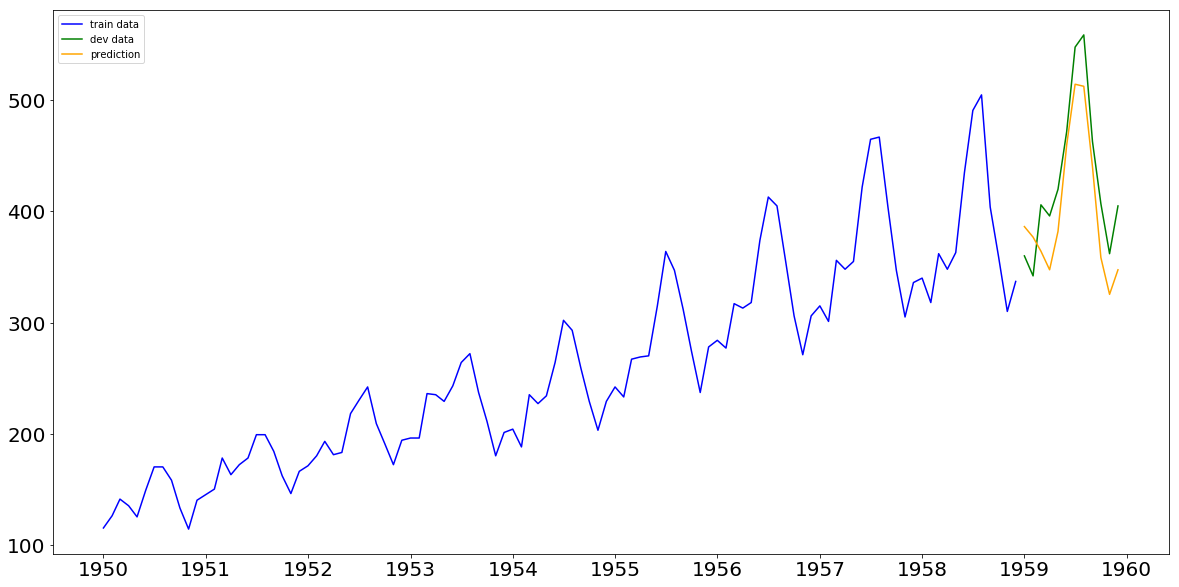

In [194]:
plot_prediction(X_train, y_train, X_dev, y_dev, y_dev_hat)